# Linear discriminant analysis
LDA is very similar to PCA, but whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes class separability.

1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix, SB, and the within-class scatter matrix, SW.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, 𝑺𝑺𝑊𝑊 −1𝑺𝑺𝐵𝐵 .
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d×k-dimensional
transformation matrix, W; the eigenvectors are the columns of this matrix.
7. Project the examples onto the new feature subspace using the transformation matrix, W.
As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(
    X_train_std[y_train==label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [4]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix:  13x13


In [5]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix:  13x13


In [6]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: ', f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix:  13x13


Selecting linear discriminants for the new feature subspace

In [7]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.7615221897938
3.176506162325064e-14
2.842170943040401e-14
2.524076602752609e-14
2.524076602752609e-14
1.7104020034602083e-14
1.7104020034602083e-14
1.5400541441701068e-14
1.4529863140519795e-14
4.66036996010505e-15
4.66036996010505e-15
4.529165348731398e-15


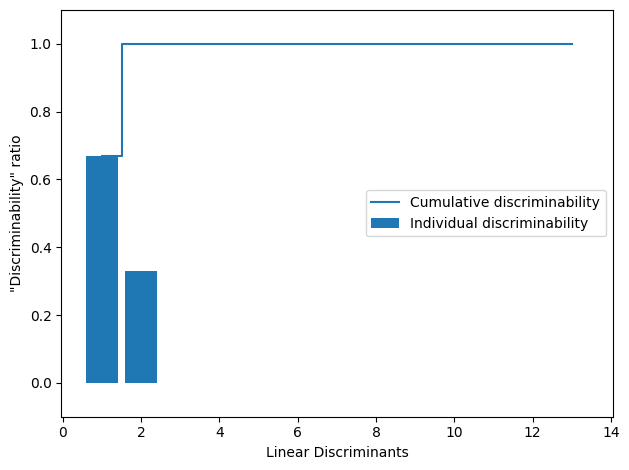

In [9]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, align='center',
label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [10]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
w

array([[-0.1481, -0.4092],
       [ 0.0908, -0.1577],
       [-0.0168, -0.3537],
       [ 0.1484,  0.3223],
       [-0.0163, -0.0817],
       [ 0.1913,  0.0842],
       [-0.7338,  0.2823],
       [-0.075 , -0.0102],
       [ 0.0018,  0.0907],
       [ 0.294 , -0.2152],
       [-0.0328,  0.2747],
       [-0.3547, -0.0124],
       [-0.3915, -0.5958]])

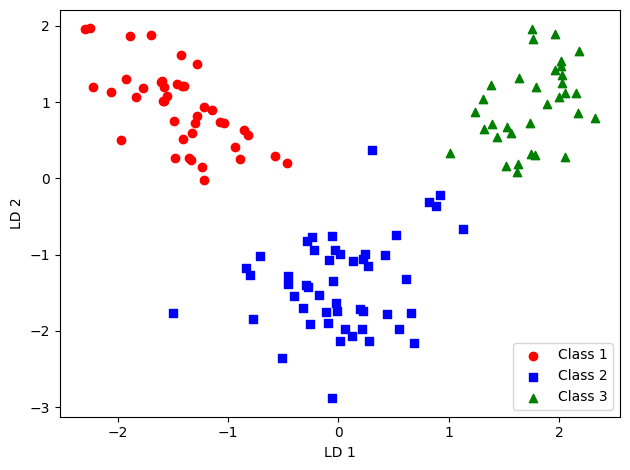

In [11]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c, label= f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()